In [ ]:
!pip install "protobuf==3.20.3"

   ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/904.0 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/904.0 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/904.0 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/904.0 kB ? eta -:--:--


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.20.0 requires protobuf>=5.28.0, but you have protobuf 3.20.3 which is incompatible.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
BATCH_SIZE = 32
IMG_SIZE = (240, 240)
DATA_DIR = "/kaggle/input/last-chance/Newest dataset/Newest dataset" 
CLASSES = ['Glass', 'Metal', 'Plastic', 'Wood']

print(f"TensorFlow Version: {tf.__version__}")

if os.path.exists(DATA_DIR):
    print(f"📂 Loading data from: {DATA_DIR}")
    
    # 1. Load the FULL dataset (100%) first
    full_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        class_names=CLASSES,
        shuffle=True # Important: Shuffle before splitting!
    )
    
    # 2. Calculate Split Sizes (Batch counts)
    # Get total number of batches
    total_batches = tf.data.experimental.cardinality(full_ds).numpy()
    
    # 10% for Validation, 10% for Testing, 80% for Training
    val_size = int(total_batches * 0.1)
    test_size = int(total_batches * 0.1)
    train_size = total_batches - val_size - test_size
    
    # 3. Perform the Split
    train_ds = full_ds.take(train_size)
    remaining = full_ds.skip(train_size)
    val_ds = remaining.take(val_size)
    test_ds = remaining.skip(val_size)
    
    print(f"✅ Data Split Successfully (80/10/10):")
    print(f"   - Training Batches: {train_size}")
    print(f"   - Validation Batches: {val_size}")
    print(f"   - Testing Batches: {total_batches - train_size - val_size}")

    # 4. Optimize for speed (Caching & Prefetching)
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Shuffle only training data to keep it random every epoch
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    print("🚀 Pipeline Optimized & Ready.")
else:
    print(f"❌ Error: Folder not found at {DATA_DIR}")

TensorFlow Version: 2.18.0
📂 Loading data from: /kaggle/input/last-chance/Newest dataset/Newest dataset
Found 14458 files belonging to 4 classes.
✅ Data Split Successfully (80/10/10):
   - Training Batches: 362
   - Validation Batches: 45
   - Testing Batches: 45
🚀 Pipeline Optimized & Ready.


In [4]:
# 1. Define Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1)
], name="data_augmentation")

def build_improved_model():
    # Input Layer
    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    
    # Apply Augmentation
    x = data_augmentation(inputs)
    
    # Base Model (EfficientNetB1)
    # Note: We do NOT use input_tensor here to allow better control over training=False
    base_model = tf.keras.applications.EfficientNetB1(
        include_top=False,
        weights='imagenet',
        input_shape=IMG_SIZE + (3,)
    )
    
    # Freeze the base model initially
    base_model.trainable = False 
    
    # Pass inputs through base model
    # IMPORTANT: training=False ensures BatchNormalization layers stay in inference mode
    x = base_model(x, training=False)
    
    # Improved Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    
    # Added Intermediate Dense Layer for better feature processing
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)  # Slightly higher dropout for regularization
    
    # Output Layer
    outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model, base_model

print("✅ Model function defined with Augmentation and Improved Head.")

✅ Model function defined with Augmentation and Improved Head.


In [5]:
import os
from sklearn.utils.class_weight import compute_class_weight

# 1. Count the images per class
# (Assumes your DATA_DIR is set from Cell 2)
class_counts = {}
y_train_labels = []

print("📊 Calculating Class Weights...")

for i, class_name in enumerate(CLASSES):
    class_path = os.path.join(DATA_DIR, class_name)
    if os.path.exists(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count
        # We need a list of all labels to calculate weights
        y_train_labels.extend([i] * count)
        print(f"   - {class_name}: {count} images")

# 2. Compute Weights
# Formula: n_samples / (n_classes * n_samples_j)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

# Convert to dictionary for Keras {0: 1.0, 1: 0.5, ...}
class_weights = dict(enumerate(class_weights_array))

print(f"\n⚖️ Final Class Weights: {class_weights}")
print("(Note: A value > 1.0 means the model will pay EXTRA attention to that class)")

📊 Calculating Class Weights...
   - Glass: 4332 images
   - Metal: 3779 images
   - Plastic: 3868 images
   - Wood: 2479 images

⚖️ Final Class Weights: {0: 0.8343721144967683, 1: 0.9564699655993649, 2: 0.9344622543950362, 3: 1.4580475998386446}
(Note: A value > 1.0 means the model will pay EXTRA attention to that class)


In [7]:
# Build the model
model, base_model = build_improved_model()

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for Phase 1
checkpoint_path = "/kaggle/working/best_model_phase_new.keras"
checkpoint = callbacks.ModelCheckpoint(
    checkpoint_path, save_best_only=True, monitor='val_accuracy', verbose=1
)
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=6, restore_best_weights=True, verbose=1
)

print("🔥 Phase 1: Training Head Layers (Frozen Base)...")

history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,  # Give it enough time to converge
    callbacks=[checkpoint, early_stop]
)

🔥 Phase 1: Training Head Layers (Frozen Base)...
Epoch 1/30


E0000 00:00:1766080183.482606     127 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetb1_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1766080206.706438     182 cuda_dnn.cc:529] Loaded cuDNN version 90300


362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5692 - loss: 1.2238
Epoch 1: val_accuracy improved from -inf to 0.73611, saving model to /kaggle/working/best_model_phase_new.keras
362/362 ━━━━━━━━━━━━━━━━━━━━ 110s 178ms/step - accuracy: 0.5693 - loss: 1.2233 - val_accuracy: 0.7361 - val_loss: 0.6913
Epoch 2/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6875 - loss: 0.7990
Epoch 2: val_accuracy improved from 0.73611 to 0.77222, saving model to /kaggle/working/best_model_phase_new.keras
362/362 ━━━━━━━━━━━━━━━━━━━━ 46s 128ms/step - accuracy: 0.6875 - loss: 0.7989 - val_accuracy: 0.7722 - val_loss: 0.6027
Epoch 3/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7261 - loss: 0.7053
Epoch 3: val_accuracy did not improve from 0.77222
362/362 ━━━━━━━━━━━━━━━━━━━━ 45s 124ms/step - accuracy: 0.7261 - loss: 0.7053 - val_accuracy: 0.7708 - val_loss: 0.5973
Epoch 4/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7325 - loss: 0.6688
Epoch 4: val_accurac

In [12]:
print("🔓 Unfreezing top layers for Fine-Tuning...")

# 1. Unfreeze the base model
base_model.trainable = True

# 2. Refreeze the bottom layers
fine_tune_at = len(base_model.layers) - 60
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 3. Recompile (Low Learning Rate)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_finetune = callbacks.ModelCheckpoint(
    "/kaggle/working/best_model_finetuned.keras", 
    save_best_only=True, 
    monitor='val_accuracy', 
    verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1
)
early_stop_finetune = callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

print("🚀 Phase 2: Fine-Tuning Started...")

# --- THE FIX IS HERE ---
# Calculate where we left off
initial_epochs = len(history_phase1.history['accuracy']) # e.g., 21
fine_tune_epochs = 20 # How many MORE epochs you want
total_epochs = initial_epochs + fine_tune_epochs

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,  # Set this to TOTAL (e.g., 41), not just 20
    initial_epoch=initial_epochs, 
    callbacks=[checkpoint_finetune, reduce_lr, early_stop_finetune]
)

🔓 Unfreezing top layers for Fine-Tuning...
🚀 Phase 2: Fine-Tuning Started...
Epoch 22/41


E0000 00:00:1766081549.195173     127 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetb1_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7020 - loss: 0.7387
Epoch 22: val_accuracy improved from -inf to 0.76597, saving model to /kaggle/working/best_model_finetuned.keras
362/362 ━━━━━━━━━━━━━━━━━━━━ 95s 176ms/step - accuracy: 0.7021 - loss: 0.7386 - val_accuracy: 0.7660 - val_loss: 0.6016 - learning_rate: 1.0000e-05
Epoch 23/41
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7461 - loss: 0.6516
Epoch 23: val_accuracy improved from 0.76597 to 0.78264, saving model to /kaggle/working/best_model_finetuned.keras
362/362 ━━━━━━━━━━━━━━━━━━━━ 58s 160ms/step - accuracy: 0.7461 - loss: 0.6515 - val_accuracy: 0.7826 - val_loss: 0.5742 - learning_rate: 1.0000e-05
Epoch 24/41
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7684 - loss: 0.6082
Epoch 24: val_accuracy improved from 0.78264 to 0.78819, saving model to /kaggle/working/best_model_finetuned.keras
362/362 ━━━━━━━━━━━━━━━━━━━━ 58s 160ms/step - accuracy: 0.7684 - loss: 0.6081 - val_accuracy: 0.7882 - v

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io

uploader = widgets.FileUpload(accept='image/*', multiple=False)
out = widgets.Output()

def on_upload_change(change):
    if not uploader.value: return
    out.clear_output()
    
    with out:
        try:
            # Handle widget version differences
            val = uploader.value
            uploaded_file = list(val)[0] if isinstance(val, (tuple, list)) else list(val.values())[0]
            
            image = Image.open(io.BytesIO(uploaded_file['content'])).convert('RGB')
            image = image.resize((240, 240))
            
            img_array = tf.keras.preprocessing.image.img_to_array(image)
            img_batch = np.expand_dims(img_array, 0)
            
            # Predict
            predictions = model.predict(img_batch, verbose=0)
            score = tf.nn.softmax(predictions[0])
            
            # EXACT SAME ORDER AS CELL 2
            final_classes = ['Glass', 'Metal', 'Plastic', 'Wood']
            
            predicted_class = final_classes[np.argmax(score)]
            confidence = 100 * np.max(score)
            
            print(f"✅ Prediction: {predicted_class.upper()}")
            print(f"📊 Confidence: {confidence:.2f}%")
            plt.imshow(image); plt.axis('off'); plt.show()
            
        except Exception as e:
            print(f"Error: {e}")

uploader.observe(on_upload_change, names='value')
print("👇 Upload an image:")
display(uploader)
display(out)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get Predictions from the Test Set
y_true = []
y_pred = []

print("⏳ Evaluating on Test Set... (This might take a moment)")

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    true_labels = np.argmax(labels.numpy(), axis=1)
    predicted_labels = np.argmax(preds, axis=1)
    
    y_true.extend(true_labels)
    y_pred.extend(predicted_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Calculate Accuracy Per Class
cm = confusion_matrix(y_true, y_pred)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# 3. Plot the Bar Chart
plt.figure(figsize=(10, 6))

# FIX: Removed 'legend=False' and 'hue' to work with your Seaborn version
bars = sns.barplot(x=CLASSES, y=class_accuracies, palette='viridis')

plt.title('Model Accuracy by Material Class (Test Set)', fontsize=15)
plt.xlabel('Material', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.1)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels
for i, acc in enumerate(class_accuracies):
    plt.text(i, acc + 0.02, f'{acc*100:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

# 4. Show Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix (Where is the model confused?)')
plt.ylabel('Actual Material')
plt.xlabel('Predicted Material')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Calculate Exact Accuracies
# (We evaluate the model on all datasets to get the final, true performance)
print("⏳ Evaluating Model on all datasets... (This may take a moment)")

# Note: verbose=0 turns off the progress bar to keep the log clean
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
val_loss, val_acc     = model.evaluate(val_ds, verbose=0)
test_loss, test_acc   = model.evaluate(test_ds, verbose=0)

print(f"✅ Training Acc:   {train_acc:.2%}")
print(f"✅ Validation Acc: {val_acc:.2%}")
print(f"✅ Test Acc:       {test_acc:.2%}")

# 2. Prepare Data for Plotting
accuracies = [train_acc, val_acc, test_acc]
labels = ['Training', 'Validation', 'Test']
colors = ['#4299E1', '#F6AD55', '#48BB78'] # Blue, Orange, Green (Similar to your reference)

# 3. Create the Chart
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracies, color=colors, edgecolor='black', alpha=0.9)

# 4. Add Styling "Like the Image"
plt.title('The Reality Check (Model Performance)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1.1)  # Set y-limit slightly above 1.0 for space
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 5. Add Percentage Labels on Top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02, 
             f'{height:.1%}', 
             ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

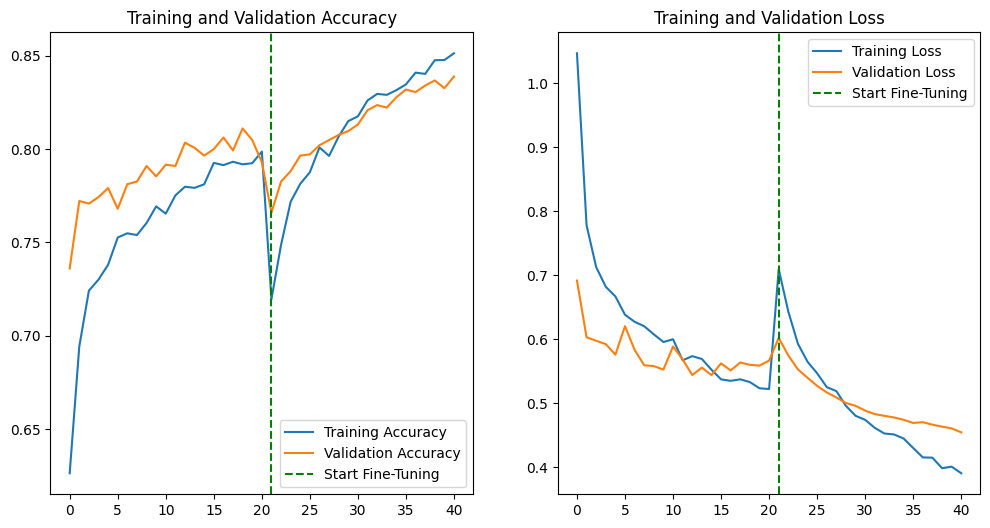

Evaluating on Test Set...
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.8228 - loss: 0.4870


In [14]:
def plot_history(history1, history2):
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    plt.figure(figsize=(12, 6))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.axvline(x=len(history1.history['accuracy']), color='green', linestyle='--', label='Start Fine-Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.axvline(x=len(history1.history['accuracy']), color='green', linestyle='--', label='Start Fine-Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history_phase1, history_finetune)

# Final Evaluation on Test Set (if you have test_ds)
if 'test_ds' in locals():
    print("Evaluating on Test Set...")
    model.evaluate(test_ds)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# --- 1. Generate Predictions on Test Data ---
print("⏳ Generating predictions for the Bar Chart... (This may take a moment)")
y_true = []
y_pred = []

# Iterate through the test dataset
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    # Convert one-hot encoded labels back to integers (e.g., [0, 1, 0, 0] -> 1)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- 2. Calculate Accuracy Per Class ---
# Create confusion matrix to see where the model was right/wrong
cm = confusion_matrix(y_true, y_pred)
# Diagonal elements are correct predictions, sum(axis=1) is total items per class
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# --- 3. Plot the Bar Chart ---
plt.figure(figsize=(10, 6))

# Create bars with a nice color palette
colors = sns.color_palette("viridis", len(CLASSES))
bars = plt.bar(CLASSES, class_accuracies, color=colors, edgecolor='black', alpha=0.8)

# Styling
plt.title('Model Accuracy by Material Class', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Material Type', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.ylim(0, 1.15) # Give some headroom for the text
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add Percentage Labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        height + 0.02, 
        f'{height:.1%}', 
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )

plt.tight_layout()
plt.show()

⏳ Generating predictions for the Bar Chart... (This may take a moment)


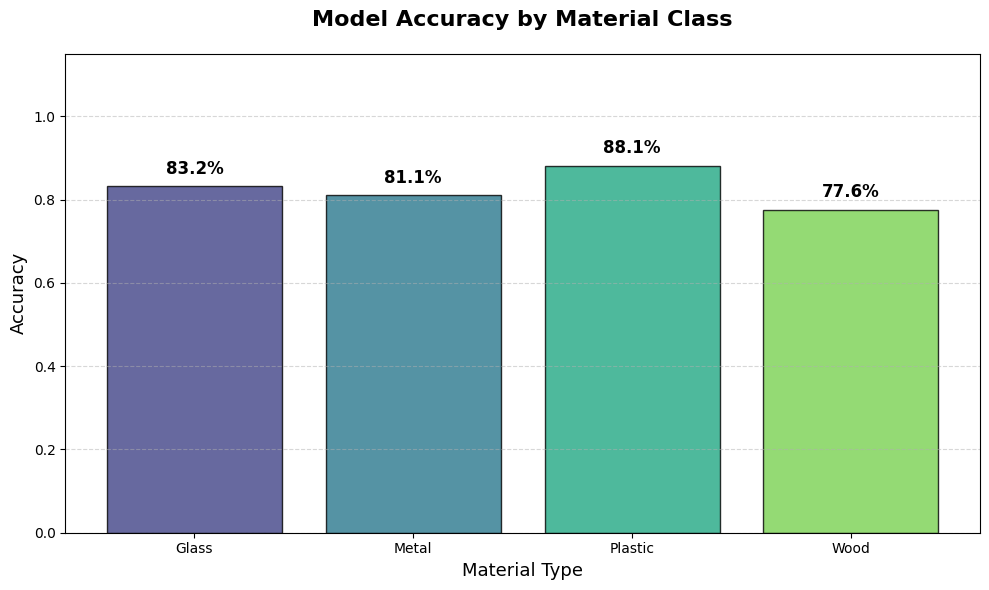

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# --- 1. Generate Predictions on Test Data ---
print("⏳ Generating predictions for the Bar Chart... (This may take a moment)")
y_true = []
y_pred = []

# Iterate through the test dataset
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    # Convert one-hot encoded labels back to integers (e.g., [0, 1, 0, 0] -> 1)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- 2. Calculate Accuracy Per Class ---
# Create confusion matrix to see where the model was right/wrong
cm = confusion_matrix(y_true, y_pred)
# Diagonal elements are correct predictions, sum(axis=1) is total items per class
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# --- 3. Plot the Bar Chart ---
plt.figure(figsize=(10, 6))

# Create bars with a nice color palette
colors = sns.color_palette("viridis", len(CLASSES))
bars = plt.bar(CLASSES, class_accuracies, color=colors, edgecolor='black', alpha=0.8)

# Styling
plt.title('Model Accuracy by Material Class', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Material Type', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.ylim(0, 1.15) # Give some headroom for the text
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add Percentage Labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        height + 0.02, 
        f'{height:.1%}', 
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )

plt.tight_layout()
plt.show()

⏳ Evaluating Model on all datasets... (This may take a moment)
✅ Training Acc:   88.36%
✅ Validation Acc: 83.89%
✅ Test Acc:       82.98%


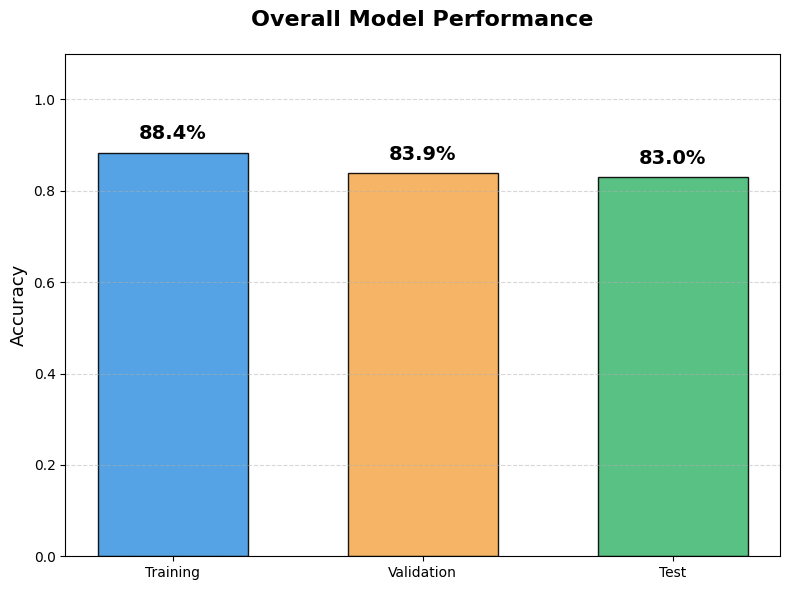

In [16]:
import matplotlib.pyplot as plt

# --- 1. Calculate Exact Accuracies ---
print("⏳ Evaluating Model on all datasets... (This may take a moment)")

# Note: verbose=0 turns off the progress bar to keep the log clean
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
val_loss, val_acc     = model.evaluate(val_ds, verbose=0)
test_loss, test_acc   = model.evaluate(test_ds, verbose=0)

print(f"✅ Training Acc:   {train_acc:.2%}")
print(f"✅ Validation Acc: {val_acc:.2%}")
print(f"✅ Test Acc:       {test_acc:.2%}")

# --- 2. Prepare Data for Plotting ---
accuracies = [train_acc, val_acc, test_acc]
labels = ['Training', 'Validation', 'Test']
# Colors: Blue (Train), Orange (Valid), Green (Test)
colors = ['#4299E1', '#F6AD55', '#48BB78'] 

# --- 3. Create the Chart ---
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, accuracies, color=colors, edgecolor='black', alpha=0.9, width=0.6)

# --- 4. Styling ---
plt.title('Overall Model Performance', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Accuracy', fontsize=13)
plt.ylim(0, 1.1)  # Set y-limit slightly above 1.0 for space
plt.grid(axis='y', linestyle='--', alpha=0.5)

# --- 5. Add Percentage Labels on Top ---
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.0, 
        height + 0.02, 
        f'{height:.1%}', 
        ha='center', va='bottom', fontsize=14, fontweight='bold'
    )

plt.tight_layout()
plt.show()